# Setup

In [1]:
import numpy as np
import pandas as pd
import pybaseball
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
from scipy.special import gammaln
from scipy.optimize import minimize

## Load data from Chapter 5

In [2]:
# Load dataframe
bd = pd.read_pickle("./data/batting_data_ch5.pkl")

# Load beta parameters
with open("./data/eb_estimate_beta_params.npy","rb") as f:
    alpha0, beta0 = np.load(f)

## 6.2 Comparing posterior distributions

Let's check the two batters mentioned in the book. Who is better, Mike Piazza or Hank Aaron?

In [3]:
bd.loc[bd.Name.isin(["Mike Piazza","Hank Aaron"]),["Name","H","AB","Avg","eb estimate Avg","PEP","q_value"]]

,Name,H,AB,Avg,eb estimate Avg,PEP,q_value
86,Mike Piazza,2127,6911,0.307770,0.305509,0.154115,0.036326
90,Hank Aaron,3771,12364,0.304998,0.303783,0.176985,0.042044


### Figure 6.1

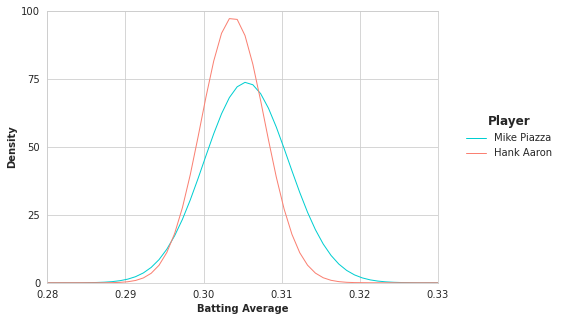

In [4]:
# Which players
players = ["Mike Piazza","Hank Aaron"]

# Make figure
with sns.axes_style("whitegrid"):
    # Fig
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()

    # Make distributions for prior and each player
    clrs = ["darkturquoise","salmon"]
    x = np.linspace(0,1,1000)
    for (row,clr) in zip(bd.loc[(bd.Name.isin(players)),:].itertuples(),clrs):
        ax.plot(x,stats.beta.pdf(x,row.alpha1,row.beta1),color=clr,lw=1,label=row.Name)

    # Add legend and clean up
    ax.legend(frameon=False,bbox_to_anchor=(1.05, .65),loc='upper left')
    ax.get_legend().set_title("Player",prop = {'size':12,'weight': "bold"})
    ax.set_xlabel("Batting Average",fontweight="bold")
    ax.set_ylabel("Density",fontweight="bold")
    ax.set_xticks(np.arange(0.28,0.34,step=0.01))
    ax.set_xlim(0.28,.33)
    ax.set_ylim(0,100)
    ax.set_yticks([0,25,50,75,100])


### Figure 6.2

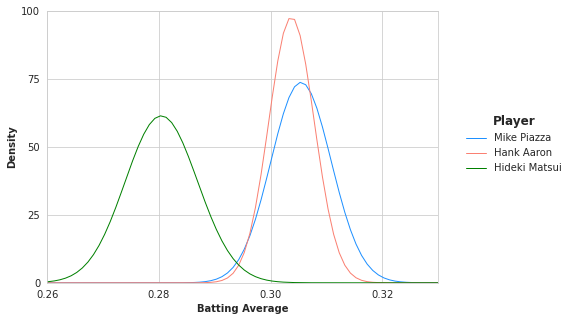

In [5]:
# Which players
players = ["Mike Piazza","Hank Aaron","Hideki Matsui"]

# Make figure
with sns.axes_style("whitegrid"):
    # Fig
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()

    # Make distributions for prior and each player
    clrs = ["dodgerblue","salmon","green"]
    x = np.linspace(0,1,1000)
    for (row,clr) in zip(bd.loc[(bd.Name.isin(players)),:].itertuples(),clrs):
        ax.plot(x,stats.beta.pdf(x,row.alpha1,row.beta1),color=clr,lw=1,label=row.Name)

    # Add legend and clean up
    ax.legend(frameon=False,bbox_to_anchor=(1.05, .65),loc='upper left')
    ax.get_legend().set_title("Player",prop = {'size':12,'weight': "bold"})
    ax.set_xlabel("Batting Average",fontweight="bold")
    ax.set_ylabel("Density",fontweight="bold")
    ax.set_xticks(np.arange(0.26,0.34,step=0.02))
    ax.set_xlim(0.26,.33)
    ax.set_ylim(0,100)
    ax.set_yticks([0,25,50,75,100])


#### 6.2.1 Simulation of posterior draws

Lets first try drawing from each player's specific beta distribution. 

In [6]:
def sample_from_beta(row,num_samples=1):
    a,b = row.loc[:,["alpha1","beta1"]].to_numpy()[0]
    return np.random.beta(a,b,size=num_samples)

num_samples = 1_000_000
piazza_simulation = sample_from_beta(bd.loc[bd.Name.isin(["Mike Piazza"]),:], num_samples=num_samples)
aaron_simulation  = sample_from_beta(bd.loc[bd.Name.isin(["Hank Aaron"]),:],  num_samples=num_samples)

print("There is a {:.2f}% that Piazza is better than Aaron!".format(100*np.count_nonzero([piazza_simulation > aaron_simulation])/num_samples))


There is a 59.93% that Piazza is better than Aaron!


#### Figure 6.3 
The joint probability density of Piazza’s and Aaron’s possible batting averages. Darker red means higher probability, and the black line represents the x = y line. Here I am just using the simulation data to plot the joint density. I am not completely sure how to plot the joint disribution as a cloud w/o sampling from the individual betas and looking at the joint. The message is the same nonetheless.

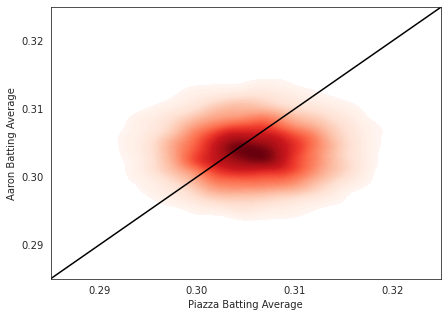

In [20]:
x = np.linspace(0,1,1000)
alpha1_piazza, beta1_piazza = bd.loc[bd.Name.isin(["Mike Piazza"]),["alpha1","beta1"]].to_numpy()[0]
alpha1_aaron , beta1_aaron  = bd.loc[bd.Name.isin(["Hank Aaron"]),["alpha1","beta1"]].to_numpy()[0]

num_samples = 10_000
joint_data = pd.DataFrame({"x": sample_from_beta(bd.loc[bd.Name.isin(["Mike Piazza"]),:], num_samples=num_samples),
                           "y": sample_from_beta(bd.loc[bd.Name.isin(["Hank Aaron"]),:],  num_samples=num_samples)})

# Make figure
with sns.axes_style("white"):
    # Fig
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()

    sns.kdeplot(data=joint_data,x="x",y="y",cmap="Reds", shade=True,levels=100)#, bw_adjust=.5)
    vals = np.linspace(0.28,0.33,1000)
    ax.plot(vals,vals,color='k')
    ax.set_xlim(0.285,0.325)
    ax.set_ylim(0.285,0.325)
    ticks = [0.29,0.30,0.31,0.32]
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xlabel("Piazza Batting Average")
    ax.set_ylabel("Aaron Batting Average")

#### 6.2.2 (Integration) & 6.2.3 (Closed-form solution)

This function is adapted from the derivation provided [here](https://www.evanmiller.org/bayesian-ab-testing.html#binary_ab_implementation). 

In [48]:
def a_b_test(alpha_a, beta_a, alpha_b, beta_b):
    '''
    From: https://www.evanmiller.org/bayesian-ab-testing.html
    alpha_a is one plus the number of successes for A
    beta_a is one plus the number of failures for A
    alpha_b is one plus the number of successes for B
    beta_b is one plus the number of failures for B
    B is the beta function
    '''
    from scipy.special import betaln as logbeta # <-- renaming function so it matches the eqns in above link
    result = 0.0
    for ii in range(int(alpha_b)-1):
        result += np.exp(logbeta(alpha_a+ii,beta_a+beta_b) - np.log((beta_b+ii)) - logbeta(1+ii, beta_b) - logbeta(alpha_a,beta_a))
    return result # <-- this is the Pr(pB > pA)

print("There is a {:.2f}% that Piazza is better than Aaron!".format((a_b_test(alpha1_aaron,beta1_aaron,alpha1_piazza, beta1_piazza,))*100))

There is a 59.07% that Piazza is better than Aaron!


Here is an alternate version using `loggamma`.

In [51]:
# code from here: https://gist.github.com/arnov/60de0b1ad62d329bc222
def calc_ab(alpha_a, beta_a, alpha_b, beta_b):
    '''
    See http://www.evanmiller.org/bayesian-ab-testing.html
    αA is one plus the number of successes for A
    βA is one plus the number of failures for A
    αB is one plus the number of successes for B
    βB is one plus the number of failures for B
    '''
    import math

    total = 0.0
    for i in range(int(alpha_b)-1): # JB edit: should be alpha_b-1 not just alpha_b.
        num = math.lgamma(alpha_a+i) + math.lgamma(beta_a+beta_b) + math.lgamma(1+i+beta_b) + math.lgamma(alpha_a+beta_a)
        den = math.log(beta_b+i) + math.lgamma(alpha_a+i+beta_a+beta_b) + math.lgamma(1+i) + math.lgamma(beta_b) + math.lgamma(alpha_a) + math.lgamma(beta_a)

        total += math.exp(num - den)
    return total

print("There is a {:.2f}% that Piazza is better than Aaron!".format((calc_ab(alpha1_aaron,beta1_aaron,alpha1_piazza,beta1_piazza))*100))

There is a 59.07% that Piazza is better than Aaron!


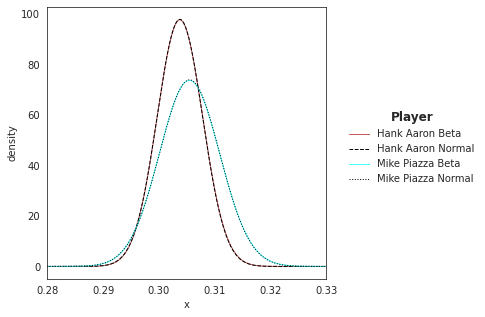

In [82]:
# Fit gaussian using beta distribution for each player.

# Piazza
x = np.linspace(0,1,10000)
alpha1_piazza, beta1_piazza = bd.loc[bd.Name.isin(["Mike Piazza"]),["alpha1","beta1"]].to_numpy()[0]
piazza_beta = stats.beta.pdf(x,alpha1_piazza, beta1_piazza)
mean_p, std_p = stats.norm.fit(piazza_simulation)
piazza_normal = stats.norm.pdf(x, mean_p, std_p)

# Aaron
alpha1_aaron , beta1_aaron  = bd.loc[bd.Name.isin(["Hank Aaron"]),["alpha1","beta1"]].to_numpy()[0]
aaron_beta = stats.beta.pdf(x,alpha1_aaron, beta1_aaron)
mean_a, std_a = stats.norm.fit(aaron_simulation)
aaron_normal = stats.norm.pdf(x, mean_a, std_a)

# Make figure
with sns.axes_style("white"):
    # Fig
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()

    ax.plot(x,aaron_beta,color='firebrick',lw=1,alpha=0.75,label="Hank Aaron Beta")
    ax.plot(x,aaron_normal,color='k',linestyle='--',lw=1, label="Hank Aaron Normal")
    ax.plot(x,piazza_beta,color='cyan',lw=1,alpha=0.75, label="Mike Piazza Beta")
    ax.plot(x,piazza_normal,color='k',linestyle=':',lw=1,label="Mike Piazza Normal")    
    ax.set_xlim(0.28,0.33)
    ax.set_xlabel("x")
    ax.set_ylabel("density")

    ax.legend(frameon=False,bbox_to_anchor=(1.05, .65),loc='upper left')
    ax.get_legend().set_title("Player",prop = {'size':12,'weight': "bold"})

In [104]:
# From here: https://www.johndcook.com/fast_beta_inequality.pdf

# Moment matching
def approximate_normal_from_beta(a,b):
    mean = a / (a+b)
    variance = (a*b) / (((a+b)**2) * (a+b+1))
    return mean, variance

# perform a/b test using normal approximation
def a_b_test_normalapproximation(alpha_a, beta_a, alpha_b, beta_b,X=0):
    # X can also be a vector if we want the full CDF --> X=np.linspace(0,1,10000)
    # approximate first distribution
    mean_a, var_a = approximate_normal_from_beta(alpha_a,beta_a)
    # approximate second disribution
    mean_b, var_b = approximate_normal_from_beta(alpha_b,beta_b)
    # Get estimate
    return stats.norm.cdf(x=X,loc=mean_b - mean_a,scale=np.sqrt(var_a + var_b))


print("There is a {:.2f}% that Piazza is better than Aaron!".format(round(100*a_b_test_normalapproximation(alpha1_piazza,beta1_piazza,alpha1_aaron,beta1_aaron),2)))

There is a 60.06% that Piazza is better than Aaron!


Let's make the plot again using the approximated (mean,std) from the reference above. 

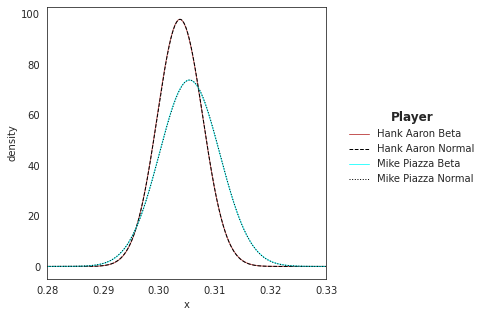

In [107]:
# Approximate Piazza distribution
mean_p, var_p = approximate_normal_from_beta(alpha1_piazza,beta1_piazza)
piazza_normal = stats.norm.pdf(x, mean_p, np.sqrt(var_p))

# Approximate Aaron disribution
mean_a, var_a = approximate_normal_from_beta(alpha1_aaron,beta1_aaron)
aaron_normal = stats.norm.pdf(x, mean_a, np.sqrt(var_a))

# Make figure
with sns.axes_style("white"):
    # Fig
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot()

    ax.plot(x,aaron_beta,color='firebrick',lw=1,alpha=0.75,label="Hank Aaron Beta")
    ax.plot(x,aaron_normal,color='k',linestyle='--',lw=1, label="Hank Aaron Normal")
    ax.plot(x,piazza_beta,color='cyan',lw=1,alpha=0.75, label="Mike Piazza Beta")
    ax.plot(x,piazza_normal,color='k',linestyle=':',lw=1,label="Mike Piazza Normal")    
    ax.set_xlim(0.28,0.33)
    ax.set_xlabel("x")
    ax.set_ylabel("density")

    ax.legend(frameon=False,bbox_to_anchor=(1.05, .65),loc='upper left')
    ax.get_legend().set_title("Player",prop = {'size':12,'weight': "bold"})

# Confidence and Credible Intervals

In [117]:
# Get Piazza data
piazza_H, piazza_AB = bd.loc[bd.Name.isin(["Mike Piazza"]),["H","AB"]].to_numpy()[0]
# Get Aaron data
aaron_H , aaron_AB  = bd.loc[bd.Name.isin(["Hank Aaron"]),["H","AB"]].to_numpy()[0]
# Make contingency table
contingency_table = pd.DataFrame({"Name": ["Mike Piazza", "Hank Aaron"],
                                  "Hits": [piazza_H, aaron_H],
                                  "Misses": [piazza_AB-piazza_H, aaron_AB-aaron_H]})
contingency_table.set_index("Name")

,Hits,Misses
Name,,
Mike Piazza,2127,4784
Hank Aaron,3771,8593


Let's perform a `chi-square` test. We can use the contingency table from above with the function `chi2_contingency` from `scipy.stats`.Otherwise, if we still have it as H/AB we can just use `chisquare`.

In [227]:
chi2, p, dof, ex = stats.chi2_contingency(contingency_table.loc[:,["Hits","Misses"]].to_numpy())

print("p-value: {}".format(round(p,3)))

# Using statsmodels
import statsmodels.stats.proportion as prop
out = prop.test_proportions_2indep(piazza_H,piazza_AB,aaron_H,aaron_AB,value=None,
                             method="score", compare='diff',
                             correction=True,
                             return_results=True)
print("p-value: {}".format(round(out.pvalue,3)))

p-value: 0.701
p-value: 0.689


Now we can compute the confidence intervals. It is not quite as straightforward to compute in `python` as in `R` so I am using this custom function from [here](https://stackoverflow.com/questions/39239087/run-a-chi-square-test-with-observation-and-expectation-counts-and-get-confidence).

In [233]:
# From here: https://stackoverflow.com/questions/39239087/run-a-chi-square-test-with-observation-and-expectation-counts-and-get-confidence
def diffprop(obs):
    """
    `obs` must be a 2x2 numpy array.

    Returns:
    delta
        The difference in proportions
    ci
        The Wald 95% confidence interval for delta
    corrected_ci
        Yates continuity correction for the 95% confidence interval of delta.
    """
    n1, n2 = obs.sum(axis=1)
    prop1 = obs[0,0] / n1
    prop2 = obs[1,0] / n2
    delta = prop1 - prop2

    # Wald 95% confidence interval for delta
    se = np.sqrt(prop1*(1 - prop1)/n1 + prop2*(1 - prop2)/n2)
    ci = (delta - 1.96*se, delta + 1.96*se)

    # Yates continuity correction for confidence interval of delta
    correction = 0.5*(1/n1 + 1/n2)
    corrected_ci = (ci[0] - correction, ci[1] + correction)

    return delta, ci, corrected_ci

diffprop(contingency_table.loc[:,["Hits","Misses"]].to_numpy())


(0.0027718389856782877,
 (-0.010803452180312468, 0.016347130151669043),
 (-0.01091624059741074, 0.016459918568767315))

Now lets compute the credible intervals

In [207]:
def credible_interval_approximation(alpha_a, beta_a, alpha_b, beta_b,X=0,q=[0.025,0.975]):
    q_low, q_high = q
    # approximate first distribution
    mean_a, var_a = approximate_normal_from_beta(alpha_a,beta_a)
    # approximate second disribution
    mean_b, var_b = approximate_normal_from_beta(alpha_b,beta_b)
    # Get params of approximate normal
    mean_diff = mean_b-mean_a
    std_diff  = np.sqrt(var_a + var_b)
    # output
    posterior = stats.norm.cdf(x=X,loc=mean_diff,scale=std_diff)
    estimate  =  mean_diff
    conf_low = stats.norm.ppf(q_low,loc=mean_diff,scale=std_diff)
    conf_high = stats.norm.ppf(q_high,loc=mean_diff,scale=std_diff)
    return posterior, estimate, conf_low, conf_high

posterior, estimate, cred_low, cred_high = credible_interval_approximation(alpha1_piazza,beta1_piazza,alpha1_aaron,beta1_aaron)

pd.DataFrame({"posterior": [posterior],
              "estimate":  [estimate],
              "cred_low": [cred_low],
              "cred_high": [cred_high]})


,posterior,estimate,cred_low,cred_high
0,0.600598,-0.001726,-0.015002,0.011549


Now we can compare random players to Mike Piazza like in the book.

In [257]:
def get_intervals(row,ref):
    # Get credible interval
    posterior, cred_estimate, cred_low, cred_high = credible_interval_approximation(ref.alpha1,ref.beta1,row.alpha1,row.beta1)
    row["mean_vs_ref_diff_cred"] = cred_estimate
    row["cred_low"] = np.abs(cred_low)
    row["cred_high"] = np.abs(cred_high)

    # Get confidence interval
    # out = prop.test_proportions_2indep(ref.H,ref.AB,row.H,row.AB,value=None,
    #                          method="score", compare='diff',
    #                          alternative='two-sided', correction=True,
    #                          return_results=True)
    table = np.array([[ref.H, ref.AB-ref.H],[row.H, row.AB-row.H]])
    delta, ci, corrected_ci = diffprop(table)
    row["mean_vs_ref_diff_conf"] = -delta
    low, high = corrected_ci
    row["conf_low"] = low
    row["conf_high"] = high
    return row

bd_trim =bd.sample(20).copy()

bd_trim = bd_trim.apply(lambda row: get_intervals(row,bd.iloc[bd.index[bd.Name.isin(["Mike Piazza"])].item()]),axis=1)

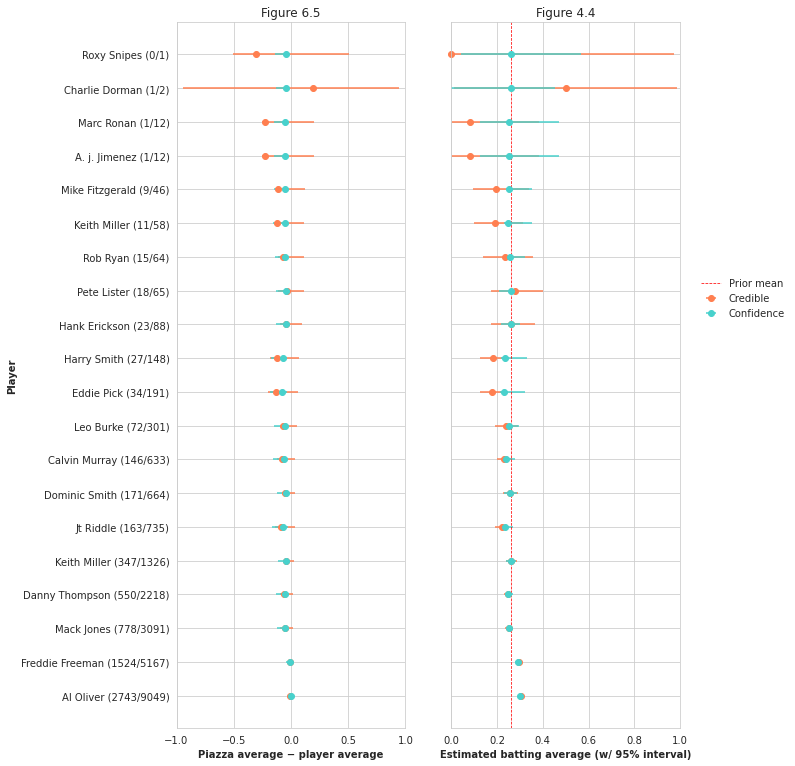

In [296]:
def make_name_with_H_AB(zipped_up):
        name, AB, H = zipped_up
        return name + " " + "(" + str(H) + "/" + str(AB) + ")"

# Make figure
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(7,10))
    gs = fig.add_gridspec(nrows=1, ncols=2, left=0.001, right=1, wspace=.2,top=.99,bottom=0.01)
    ax = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])

    # Sort by ABs
    bd_trim = bd_trim.sort_values(by="AB",ascending=False)
    
    # Get credible intervals as list of tuples
    credible_intervals   = np.abs(bd_trim.loc[:,["cred_low","cred_high"]].transpose().to_numpy())
    confidence_intervals = np.abs(bd_trim.loc[:,["conf_low","conf_high"]].transpose().to_numpy()) #np.vstack((np.absolute(bd_rand.loc[:,"CI_Clopper_low"] - bd_rand.loc[:,"Avg"]),np.absolute(bd_rand.loc[:,"CI_Clopper_high"] - bd_rand.loc[:,"Avg"])))
    ax.errorbar(x=bd_trim.loc[:,"mean_vs_ref_diff_conf"],y=np.arange(len(bd_trim)),xerr=confidence_intervals,color='coral',fmt='o',label="Confidence")
    ax.errorbar(x=bd_trim.loc[:,"mean_vs_ref_diff_cred"],y=np.arange(len(bd_trim)),xerr=credible_intervals,color='mediumturquoise',fmt='o',label="Credible")

    # Clean up
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax.set_xlim(-1,1)
    ax.set_yticks(np.arange(len(bd_trim)))   
    yticklabs = [make_name_with_H_AB(ii) for ii in zip(bd_trim.Name.to_list(), bd_trim.AB.to_list(), bd_trim.H.to_list())]
    ax.set_yticklabels(yticklabs)
    ax.set_xlabel("Piazza average − player average",fontweight="bold")
    ax.set_ylabel("Player",fontweight="bold")
    ax.title.set_text("Figure 6.5")


    credible_intervals = bd_trim.loc[:,["ci_low_diff","ci_high_diff"]].transpose().to_numpy()
    confidence_intervals = np.vstack((np.absolute(bd_trim.loc[:,"CI_Clopper_low"] - bd_trim.loc[:,"Avg"]),np.absolute(bd_trim.loc[:,"CI_Clopper_high"] - bd_trim.loc[:,"Avg"])))
    ax1.errorbar(x=bd_trim.loc[:,"Avg"],y=np.arange(len(bd_trim)),xerr=confidence_intervals,color='coral',fmt='o',label="Credible",clip_on=False,alpha=1)
    ax1.errorbar(x=bd_trim.loc[:,"eb estimate Avg"],y=np.arange(len(bd_trim)),xerr=credible_intervals,color='mediumturquoise',fmt='o',label="Confidence",clip_on=False)
    ax1.axvline(x=stats.beta(alpha0,beta0).mean(),color='r',linestyle='--',lw=.75,label="Prior mean")
    
    # Clean up
    ax1.set_yticks(np.arange(len(bd_trim)))
   
    def make_name_with_H_AB(zipped_up):
        name, AB, H = zipped_up
        return name + " " + "(" + str(H) + "/" + str(AB) + ")"

    ax1.set_yticklabels(len(yticklabs)*[' '])
    ax1.set_xlabel("Estimated batting average (w/ 95% interval)",fontweight="bold")
    ax1.legend(frameon=False,bbox_to_anchor=(1.05, .65),loc='upper left')
    ax1.set_xlim(0,1)    
    ax1.title.set_text("Figure 4.4")
